Automatisation de l'analyse des transcriptions 

TODO:
* regarder au niveau des réparations de dialogue et les changements de phase lex
* regarder les blancs ⇒ est-ce que ça prédit le changement de thème
* regarder les taggers de speech act (= actes de dialogue, réparation etc), taux de répétitions, taux de recouvrement lexical entre les IPUs (interloc)
* prédire à partir des features si le participant parle avec un robot ou un humain
comparer les distributions des IPUs / blancs
* features plus complexes: alignement hétérorépétitions + complexité croisée (alignement)

La question est de voir si sur certains éléments la personnalité importe peu ⇒ voir pour automatiser les éléments de personnalité ?


# Imports

In [1]:
import numpy as np
import pandas as pd
import spacy as sp

In [2]:
import glob
import os,sys,inspect
import argparse
import re
import ast

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
from xml.etree import ElementTree

In [6]:
CURRENTDIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
CURRENTDIR

'/Users/neako/Documents/Cours-MasCo/M1_internship/convers'

In [7]:
sys.path.insert(0,'%s/SPPAS'%CURRENTDIR)
sys.path.insert(3,CURRENTDIR)

In [8]:
import SPPAS.sppas.src.anndata.aio.readwrite as spp

In [9]:
from textblob import TextBlob

In [10]:
from collections import Counter

# Tag with Spacy

### Extract with SPPAS
<img src="anndata.png" />

In [11]:
def extract_tier(file_name, tier_name="Transcription"):
    """Read file and extract tier for analysis (either left or right tier)
    
    Input:
    -----------
    file_name: str
        name of file to be analysed
    tier_name: str 
        tiers to look for before using IPUs
    
    Output:
    -----------
    tier: sppasTier
    """
    parser = spp.sppasRW(file_name)
    trs = parser.read()
    if tier_name in [tier.get_name() for tier in trs]: # needs checking since missing tier_name still return sth
        tier = parser.read().find(tier_name)
    else:
        tier = parser.read().find("IPUs")
    return tier

In [12]:
def get_interval(sppasObject):
    """ Return the transcriped text and the IPU start/stop points for a given annotation.
    
    Input:
    -----------
    sppasObject: sppasAnnotation
    
    Output:
    -----------
    label: str
    [start, stop]: array of floats
    [start_radius, stop_radius]: array of floats
    """
    # speech
    label = sppasObject.serialize_labels() # labels => returns speech only
    # location
    location = sppasObject.get_location()[0][0]
    start = location.get_begin().get_midpoint()
    stop = location.get_end().get_midpoint()
    # the radius represents the uncertainty of the localization
    start_radius = location.get_begin().get_radius()
    stop_radius = location.get_end().get_radius()

    return label, [start, stop], [start_radius, stop_radius]

def get_ipu(tier, minimum_length = 0.5):
    """List all IPUs for one tier and returns transcribed text (if not empty) and start/stop points.
    
    Input:
    -----------
    tier: sppasTier
    minimum_length: float
        duration of short answers to remove
    
    Output:
    -----------
    p: pd.DataFrame
    """
    d = []

    for sppasOb in tier:
        label, [start, stop], [start_r, stop_r] = get_interval(sppasOb)
        if label in ["#", "", " ", "***", "*"]:
            continue
        else:
            if (stop - start) >= minimum_length:
                d.append({'label': label, 'start':start, 'stop':stop, 'duration':stop - start})
    return pd.DataFrame(d)

In [13]:
data = get_ipu(extract_tier('convers/head/Transcriptions/S04_Sess3_CONV2_002-conversant.TextGrid'))
print(data.shape)
print(' '.join(data.label.values))
data.head()

(7, 4)
cette pomme est à l'envers on dirait un $Spiderman$ cette pomme tu as une idée du message elle combat peut-être la mauvaise nourriture tu as une idée du message c'est un logo d'un club de végétarien qu'est ce que t'en penses


,label,start,stop,duration
0,cette pomme est à l'envers,2.109887,3.729977,1.620091
1,on dirait un $Spiderman$ cette pomme,4.260000,6.289977,2.029977
2,tu as une idée du message,10.364989,11.789977,1.424989
3,elle combat peut-être la mauvaise nourriture,14.949977,17.309977,2.360000
4,tu as une idée du message,24.489977,25.929977,1.440000


In [12]:
data = get_ipu(extract_tier('convers/head/Transcriptions/S09_Sess1_CONV1_001-participant.TextGrid'))
print(len(' '.join(data.label.values).split(' ')), data.shape) # SPPAS TEST
print(' '.join(data.label.values))

86 (14, 4)
bonjour $Morgane$ on dirait une ça fait penser euh euh parc d'attraction avec euh avec trou la citrou- un peu comme une citrouille mais en forme d'aubergine ok j'essaye c'est mieux comme ça voilà donc je euh oui ça me fait penser aux citrouilles dans lesquelles on met une bougie euh pour euh oui euh faut les écorcher aussi pour pouvoir mettre la bougie dedans un peu ouais @ donc euh ouais c'est étonnant pour un fruit -fin pour un légume justement euh vision d'horreur c'était


In [183]:
data.shape

(0, 0)

### Analyse with Spacy
> list of tags https://spacy.io/api/annotation#pos-tagging

Tags matching between Spacy and MarsaTag:

**Used by Spacy vs Kept for MarsaTag**
```
    ADJ	adjective	big, old, green, incomprehensible, first	-- OK
    ADP	adposition	in, to, during					-- Use PREP (preposition + postposition = ADP)
    ADV	adverb	very, tomorrow, down, where, there	-- OK
    AUX	auxiliary	is, has (done), will (do), should (do)	-- Use VERB
    CONJ	conjunction	and, or, but					-- OK
    CCONJ	coordinating conjunction	and, or, but	-- Can be kept with Cc / Use CONJ
    DET	determiner	a, an, the							-- OK
    INTJ	interjection	psst, ouch, bravo, hello	-- OK
    NOUN	noun	girl, cat, tree, air, beauty		-- OK
    NUM	numeral	1, 2017, one, seventy-seven, IV, MMXIV	-- Use DET
    PART	particle	’s, not,				-- Use ADV (adverbe de négation notamment)
    PRON	pronoun	I, you, he, she, myself, themselves, somebody	-- OK
    PROPN	proper noun	Mary, John, London, NATO, HBO	-- Use NOUN
    PUNCT	punctuation	., (, ), ?						-- OK
    SCONJ	subordinating conjunction	if, while, that	-- Can be kept with Cs / Use CONJ
    SYM	symbol	$, %, §, ©, +, −, ×, ÷, =, :), 😝		-- Use X
    VERB	verb	run, runs, running, eat, ate, eating	-- OK
    X	other	sfpksdpsxmsa							-- OK
    SPACE	space
```

In [35]:
nlp = sp.load('fr_core_news_sm')

In [13]:
def tag_one(sentence, nlp=sp.load('fr_core_news_sm')):
    """Extract POS tags for one sentence or one - aligning with MarsaTag (simplified output: no Cc nor Cs)
    
    Input:
    --------
    sentence: str
        sentence extracted from Textgrid
    nlp: spacy language model
        default: 'fr_core_news_sm'
    
    Output:
    --------
    p_spacy: pd.DataFrame
        shape [form, pos]
    """
    p_spacy = []
    d_marsa = {'ADJ': 'ADJ', 'ADP':'PREP', 'ADV': 'ADV', 'AUX': 'VERB', 'CONJ':'CONJ', 'CCONJ':'CONJ', \
              'DET':'DET', 'INTJ': 'INTJ', 'NOUN':'NOUN', 'NUM':'DET', 'PART':'ADV', 'PRON':'PRON', \
              'PROPN':'NOUN', 'PUNCT':'PUNCT', 'SCONJ':'CONJ', 'SYM':'X', 'VERB':'VERB', 'X':'X', 'SPACE':'SPACE'}
    for d in nlp(sentence):
        try:
            p_spacy.append({'form':d, 'original_pos':d.pos_, 'pos': d_marsa[d.pos_]})
        except:
            print(d, d.pos_)
    return pd.DataFrame(p_spacy)

In [15]:
tag_one(' '.join(data.label.values).replace('$', '')).head(15)

,form,original_pos,pos
0,cette,DET,DET
1,pomme,ADV,ADV
2,est,AUX,VERB
3,à,ADP,PREP
4,l',DET,DET
5,envers,PROPN,NOUN
6,on,PRON,PRON
7,dirait,VERB,VERB
8,un,DET,DET
9,Spiderman,PROPN,NOUN


# Tag with MarsaTag

### Automate file reading

In [14]:
def one_marsa(input_path, locutor = 'Transcription', output_path='log.xml'):
    """Execute one parsing of MarsaTag with CLI command, saves as XML
    
    MarsaTag arguments:
        * -r: format (Textgrid)
        * -pt: tier
        * --oral
        * -P: POS
    
    Input:
    ---------
    input_path: str
        local path, Jupyter cannot access files outside of root
    locutor: str
        tiers to look for before using IPUs
    output_path: str
        local path, XML file, default: log.xml
    """
    s = "./MarsaTag/MarsaTag-UI.sh --cli -r praat-textgrid -pt {} -P --oral ".format(locutor)
    #os.system(s + input_path + ' > ' + output_path)
    print(os.popen(s + input_path + ' > ' + output_path).read())

In [43]:
one_marsa('convers/head/Transcriptions/S021_Sess4_CONV4_006-conversant.TextGrid', 'test.xml')

In [15]:
def read_marsa(file_path):
    """Read XML file and return list of tokens
    
    Known structure:
    ---------
    <?xml version='1.0' encoding='UTF-8'?>
    <?xml-stylesheet type="text/xsl" href="mars.xsl"?>
    <document format="MARS_1.0">
        <sample>
        
        ... List of tokens:
        <token form="..." regex_type="..." features="...">
            ... One solution and several propositions:
            <solution msc=".." type="..."/>
            <proposition msc=".." frequency=".."/>
        </token>
        
        </sample>
    </document>
    
    Input:
    ---------
    file_path: str
        local path, Jupyter cannot access files outside of root, XML file
    
    Output:
    ---------
    tree: xml.etree.ElementTree.Element
    """
    tree = ElementTree.parse(file_path)
    # getroot() gets document, getchildren()[0] gets sample ==> access tokens
    return tree.getroot().getchildren()[0] 

### Analyse Tags

In [16]:
def marsatag_to_sentence(document, remove_punct=False, remove_ipu=True):
    sentence = ''
    for child in document:
        if child.tag == 'token':
            sentence += '' if (len(sentence) == 0 or child.attrib['form'] in [',', '.', "'"]) else ' '
            sentence += child.attrib['form']
    return sentence

In [17]:
def marsatag_to_pandas(document, with_inserted=True):
    """Select words & tags from xml 
    
    Input:
    -------
    document: xml.etree.ElementTree.Element
    with_inserted: bool
        whether to remove punctuation inserted by MarsaTag
    
    Output:
    -------
    sentence: dataframe
        shape ['form', 'pos', 'lemma', 'inserted']
    """
    sentence = []
    d = {'A': 'ADJ', 'D':'DET', 'R': 'ADV', 'V': 'VERB', 'C': 'CONJ', 'N': 'NOUN', 
         'S':'PREP', 'W':'PUNCT', 'I':'INTJ', 'P':'PRON', 'U':'X'}
    for child in document:
        if child.tag == 'token':
            # first child is solution, if exists
            try:
                sentence.append({'form': child.attrib['form'], \
                             'pos': d[child.attrib['features'][0]], \
                             'lemma': None if 'lemma' not in child.attrib.keys() else child.attrib['lemma'], \
                             'inserted': (child.attrib['regex_type'] == 'inserted') \
                            })
            except: # erreur de type """<token form="-" regex_type="Ponct_Wm1">"""
                sentence.append({'form': child.attrib['form'], \
                             'pos': 'PUNCT', \
                             'lemma': None if 'lemma' not in child.attrib.keys() else child.attrib['lemma'], \
                             'inserted': (child.attrib['regex_type'] == 'inserted') \
                            })
    if with_inserted:
        return pd.DataFrame(sentence)
    else:
        p = pd.DataFrame(sentence)
        return p[~p.inserted]

In [ ]:
marsatag_to_pandas(read_marsa('marsa_output/S02_Sess1_CONV1_003-participant.xml'), with_inserted=False).head(10)

# Complexity functions

In [18]:
def lexical_richness(df):
    return df[(df.pos == 'ADV') | (df.pos == 'ADJ')].shape[0] / df.shape[0]

def linguistic_complexity(df):
    return df[(df.pos == 'CONJ') | (df.pos == 'PREP') | (df.pos == 'PRON')].shape[0] / df.shape[0]

In [19]:
def ipu_length(df):
    # Cannot be used with MarsaTag Output
    return df.duration.mean()

In [20]:
# https://regex101.com
# https://regexr.com

patterns_dic = {' [sS]pider[. -]{0,1}man ': ' Spiderman ', 
                ' [bB]at[. -]{0,1}man ': ' Batman ', ' \[(.+?)\] ':' ', ' (\w+-|-\w+) ':' ', "' ":"'"}

In [21]:
def clean_text(text, patterns_dic):
    # remove '$'
    t = text.replace('$', '')
    # replace patterns
    for k,v in patterns_dic.items():
        t = re.sub(k,v,t)
    return t

In [22]:
def parse_sentiment(s:str):
    # https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/
    blob = TextBlob(s)
    return blob.sentiment

In [23]:
def extract_text(df, replace_in_text=True, join_with=' '):
    if replace_in_text:
        return clean_text(' '.join(df.form.values), patterns_dic)
    else:
        return ' '.join(df.form.values)

In [24]:
def extract_sentiment(df, replace_in_text=True, join_with=' '):
    return parse_sentiment(extract_text(df, replace_in_text=True, join_with=' '))[0]

In [25]:
def extract_subjectivity(df, replace_in_text=True, join_with=' '):
    return parse_sentiment(extract_text(df, replace_in_text=True, join_with=' '))[1]

In [26]:
OK_FORMS = [u"o.k.",u"okay",u"ok",u"OK",u"O.K."]
VOILA_FORMS = [u"voilà",u"voila"]
DACCORD_FORMS = [u"d'accord",u"d' accord"]
LAUGHTER_FORMS = [u'@',u'@ @',u'@@']
EMO_FORMS = [u'@',u'@ @',u'@@',u'ah',u'oh']

REGULATORY_DM_SET = set([u"mh",u"ouais",u"oui",u"o.k.",u"okay",u"ok",u"OK",u"O.K.",u"d'accord",u"voilà",u"voila",u'bon',u"d'",
u"accord",u'@',u'@ @',u'@@',u'non',u"ah",u"euh",u'ben',u"et",u"mais",u"*",u"heu",u"hum",u"donc",u"+",u"eh",u"beh",u"donc",u"oh",u"pff",u"hein"])

FILLED_PAUSE_ITEMS = [u"euh",u"heu",u"hum",u"mh"]
SILENCE = [u'+',u'#',u'',u'*']
LAUGHTER = [u'@',u'@@']

MAIN_FEEDBACK_ITEMS = [u"mh",u"ouais",u"oui",u'non',u'ah',u"mouais"]+ OK_FORMS + VOILA_FORMS + DACCORD_FORMS + LAUGHTER_FORMS
MAIN_DISCOURSE_ITEMS = [u"alors",u"mais",u"donc",u'et',u'puis',u'enfin',u'parceque',u'parcequ',u'ensuite']
MAIN_PARTICLES_ITEMS = [u"quoi",u"hein",u"bon",u'mais',u'ben',u'beh',u'enfin',u'vois',u'putain',u'bref']

In [27]:
def count_terms(s:str, item_list:list):
    q = 0
    for it in item_list:
        q += len(re.findall(it, s))
    return q

In [48]:
def count_syllables(s):
    """Counting syllables (a good approximation for syllables is the number of vowels phonemes in the text)
    Rules:
    * replacing qu --> q (since 'u' is silent)
    * removing final 'e' and plural 'es' (basically words longer than 4)

    Input:
    -----------
    s: str
        text to parse
    Output:
    -----------
    len: int
        number of vowels/syllables
    """
    vowels = ['ouai','eui','uei','yeu','oeu','eau','uoi','oui','aie','eoi','eai','ea','eo','eâ','uê','uî', 'ui','eû','oî','oû','oi','ué','où','io','ie','ue','oy','ai','eu','ei','au','ou','ée','ë','ü','ï','â','ô','ê','î','û','è','à','ù','é','y','i','a','e','o','u']
    s1 = s.replace('qu','q')

    rules_list = []
    for wd in s1.split():
        if len(wd) <= 2:
            rules_list.append(wd)
        elif wd[-1] == 'e':
            rules_list.append(wd[:-1])
        elif wd[-2:] == 'es' and len(wd) > 4:
            rules_list.append(wd[:-2])
        else:
            rules_list.append(wd)
    rules_list = ' '.join(rules_list)

    # replacing all vowels for easier count - starting with rarest/longest phonemes 
    for vw in vowels:
        rules_list = rules_list.replace(vw, "XXX")

    return len(re.findall('XXX',rules_list))

# Execute function
### Testing pipeline
Note: POS tags must be aligned

In [29]:
def example_analysis(textgrid_path, with_inserted=True):
    """Test all functions except Complexity functions
    """
    # Marsa: generate XML then analyse
    one_marsa(textgrid_path)
    root = read_marsa('log.xml')
    p_marsa = marsatag_to_pandas(root, with_inserted=with_inserted).reset_index(drop=True)
    # Spacy: read TextGrid then analyse
    tier = extract_tier(textgrid_path)
    data = get_ipu(tier)
    p_spacy = tag_one(' '.join(data.label.values))
    # Merge
    print(p_marsa.shape, p_spacy.shape)
    return p_marsa.join(p_spacy, lsuffix='_marsa', rsuffix='_spacy')
    #return p_marsa, p_spacy

In [96]:
#conv = 'S01_Sess1_CONV1_001'
#conv = 'S02_Sess1_CONV1_001'
#conv = 'S03_Sess2_CONV2_002'
conv = 'S05_Sess3_CONV1_005'
textgrid_path = 'convers/head/Transcriptions/{}-conversant.TextGrid'.format(conv)
example_analysis(textgrid_path, False).to_excel('marsa_spacy_{}.xlsx'.format(conv), index=False, header=True)

/Users/neako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


(95, 4) (94, 3)


### Adding complexity measures

In [29]:
def extract_stats(p_pos, cplx_functions, to_pandas=True):
    """Analyse with all functions
    
    Input:
    ----------
    p: pd.DataFrame
        shape [word, pos_tag], extracted either from Spacy or MarsaTag
    cplx_functions: array
        list of complexity functions to use on the interaction
    to_pandas: bool
        whether to return data as dataframe or list of dict
        
    Output:
    ----------
    d: pd.Series
        shape [function_name, result]
    """
    d = {}
    for f in cplx_functions:
        d[f.__name__] = f(p_pos)
    if to_pandas:
        return pd.Series(d)
    else:
        return d

In [31]:
txg = 'convers/head/Transcriptions/S01_Sess1_CONV1_001-conversant.TextGrid'
tier = extract_tier(txg)
data = get_ipu(tier)
p_spacy = tag_one('. '.join(data.label.values))

extract_stats(p_spacy, [lexical_richness, linguistic_complexity])

lexical_richness         0.207921
linguistic_complexity    0.336634
dtype: float64

### Batch Analysis

**File location**
<img src="file_loc.png" />

In [30]:
def filename_analyser(fn):
    """
    example: S19_Sess3_CONV2_002-conversant.TextGrid
    """
    [sub, block, conv, nb] = fn.replace('.TextGrid', '').split('_')
    [nb, tier] = nb.split('-')
    return int(sub[1:]), int(block.replace('Sess', '')), int(conv.replace('CONV', '')), int(nb), tier

New folder architecture:

In [74]:
def folder_analysis(input_folder, cplx_functions, 
                    pos_analyser='marsa', 
                    ipu_analysis=False, 
                    quantity_analysis=False,
                    speech_rate=False,
                    marsa_exists=False, 
                    with_inserted=False,
                    minimum_length=0.5):
    """Apply MarsaTag to all .TextGrid files to get XML
    
    Input:
    ---------
    input_folder: str
        local path, Jupyter cannot access files outside of root
    cplx_functions: array
        list of complexity functions to use on the interaction
    pos_analyser: str
        in ['marsa', 'spacy'], default 'marsa'
    ipu_analysis: bool
        whether to use spacy for IPUs analysis or not, default False
    quantity_analysis: bool
        whether to compute quantity metrics 
        count_terms(s, MAIN_FEEDBACK_ITEMS), 
        count_terms(s, MAIN_DISCOURSE_ITEMS), 
        count_terms(s, FILLED_PAUSE_ITEMS)
    speech_rate: bool
        whether to add counting of syllables and speech rate - based on extracted text
    marsa_exists: bool
        whether to create folders for marsa analysis since exists
    with_inserted: bool
        whether to add inserted punctuation (MarsaTag) in analysis
    minimum_length: float
        duration of short answers to remove - for Spacy analysis
    
    Output:
    ---------
    p: pd.DataFrame
        results of complexity functions for each conversation
    s: dict (json)
        extracts of each file
    """
    p = []
    s = {}
    for f in sorted(os.listdir(input_folder)):
        if '.TextGrid' in f: # removing .DS_Store and other files
            sub, block, conv, nb, tier = filename_analyser(f)
            # if marsa create output folder and analyse
            fp_in = os.path.join(input_folder, f)
            d = {}
            if pos_analyser == 'marsa':
                try:
                    fp_out = os.path.join('marsa_output', f.replace('.TextGrid', '.xml'))
                    if (not marsa_exists):
                        if not 'marsa_output' in os.listdir(CURRENTDIR):
                            os.makedirs('marsa_output')
                        if f.replace('.TextGrid', '.xml') not in os.listdir('marsa_output'):
                            print('Analysing '+f)
                            one_marsa(fp_in, output_path=fp_out)
                    document = read_marsa(os.path.join('marsa_output', f.replace('.TextGrid', '.xml')))
                    p_analysis = marsatag_to_pandas(document, with_inserted=with_inserted)
                except:
                    print(f)
            # if spacy or ipu analysis load file from .textgrid
            if (pos_analyser == 'spacy') or (ipu_analysis) or (quantity_analysis):
                trs = extract_tier(fp_in)
                data = get_ipu(trs, minimum_length)
                if (pos_analyser == 'spacy'):
                    try:
                        p_analysis = tag_one('. '.join(data.label.values))
                    except:
                        print(fp_in)
                        
            d = extract_stats(p_analysis, cplx_functions, to_pandas=False)
            # add to data
            d['locutor'] = sub
            d['tier'] = tier
            d['block'] = block
            d['conv'] = conv
            d['it'] = nb
            d['conv_id_unif'] = 3*(d['block']-1)+(d['it']-1)//2
            d['nb_tokens'] = p_analysis.shape[0]
            # add ipu_analysis to d # potential issue empty file
            if ipu_analysis and ('duration' in data.columns):
                d['mean_ipu_lgth'] = data.duration.mean() 
                d['sum_ipu_lgth'] = data.duration.sum()
                d['ratio_silence_lgth'] = (59-d['sum_ipu_lgth'])/59
            if quantity_analysis:
                sp = ' '.join(data.label.values)
                d['qt_feedback'] = count_terms(sp, MAIN_FEEDBACK_ITEMS)
                d['qt_discourse'] = count_terms(sp, MAIN_DISCOURSE_ITEMS)
                d['qt_filled_pause'] = count_terms(sp, FILLED_PAUSE_ITEMS)
                for col in ['qt_discourse', 'qt_feedback', 'qt_filled_pause']:
                    d[col.replace('qt', 'ratio')] = d[col] / d['nb_tokens']
            if speech_rate:
                d['count_syllables'] = count_syllables(d['extract_text'])
                d['speech_rate'] = d['count_syllables']/d['sum_ipu_lgth']
                if ipu_analysis:
                    # removing laugther only ipus
                    j = re.compile('[aeiouéèêàûùôïyAEIOUY]')
                    #d['speech_rate_mean'] = (data.label.apply(lambda x: (count_syllables(x)))/data.duration).mean()
                    #d['speech_rate_min'] = (data.label.apply(lambda x: (count_syllables(x)))/data.duration).min()
                    #d['speech_rate_max'] = (data.label.apply(lambda x: (count_syllables(x)))/data.duration).max()
                    d['speech_rate_mean'] = (data.apply(lambda x: (count_syllables(x.label))/x.duration if re.search(j,x.label) is not None else None, axis=1)).mean()
                    d['speech_rate_min'] = (data.apply(lambda x: (count_syllables(x.label))/x.duration if re.search(j,x.label) is not None else None, axis=1)).min()
                    d['speech_rate_max'] = (data.apply(lambda x: (count_syllables(x.label))/x.duration if re.search(j,x.label) is not None else None, axis=1)).max()
                    d['speech_rate_2'] = (data.label.apply(lambda x: count_syllables(x) if re.search(j,x) is not None else None)).sum()/(data.apply(lambda x: x.duration if re.search(j,x.label) is not None else None, axis=1)).sum()
            p.append(d)
            d['data'] = p_analysis
            s[f] = d
        
    return pd.DataFrame(p), s

In [33]:
p,s = folder_analysis('convers/head/Transcriptions', [lexical_richness, linguistic_complexity], \
                      marsa_exists=False)
p.head()

/Users/neako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


S09_Sess4_CONV2_002-participant.TextGrid
S16_Sess3_CONV2_004-conversant.TextGrid


,block,conv,data,it,lexical_richness,linguistic_complexity,locutor,tier
0,1,1,form inserted lemma pos...,1,0.144737,0.394737,1,conversant
1,1,1,form inserted lemma pos 0 ...,1,0.191489,0.404255,1,participant
2,1,1,form inserted lemma ...,3,0.198198,0.342342,1,conversant
3,1,1,form inserted lemma ...,3,0.163265,0.306122,1,participant
4,1,1,form inserted lemma pos 0...,5,0.123810,0.333333,1,conversant


In [34]:
p.block.unique()

array([1, 2, 3, 4])

# Analyse results
* plot as 2D, color with subject / agent - will need to get which human agent when
* evolution?
* save data as csv

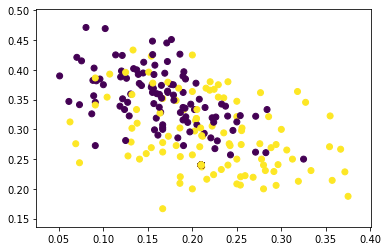

In [56]:
# select left / right only
loc = 'conversant'
plt.scatter(p[p.tier == loc]['lexical_richness'], p[p.tier == loc]['linguistic_complexity'], \
            c=p[p.tier == loc]['conv'])

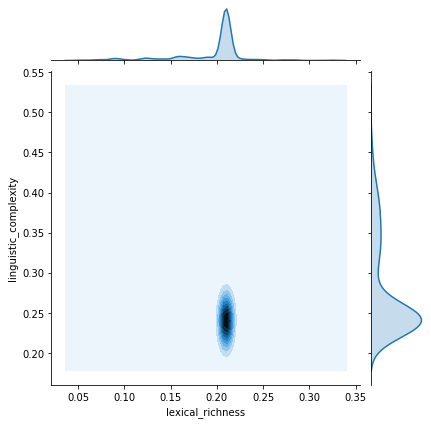

In [75]:
sns.jointplot(p[(p.tier == loc) & (p.conv == 1)].lexical_richness, 
            p[(p.tier == loc) & (p.conv == 1)].linguistic_complexity, kind='kde')

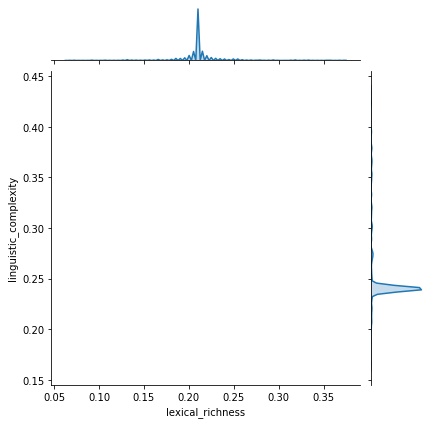

In [76]:
sns.jointplot(p[(p.tier == loc) & (p.conv == 2)].lexical_richness, 
            p[(p.tier == loc) & (p.conv == 2)].linguistic_complexity, kind='kde')

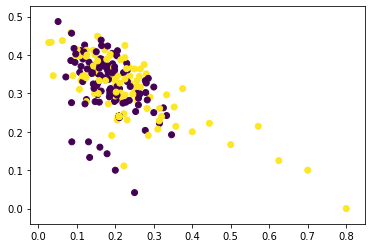

In [99]:
loc = 'participant'
plt.scatter(p[p.tier == loc]['lexical_richness'], p[p.tier == loc]['linguistic_complexity'], \
            c=p[p.tier == loc]['conv'])

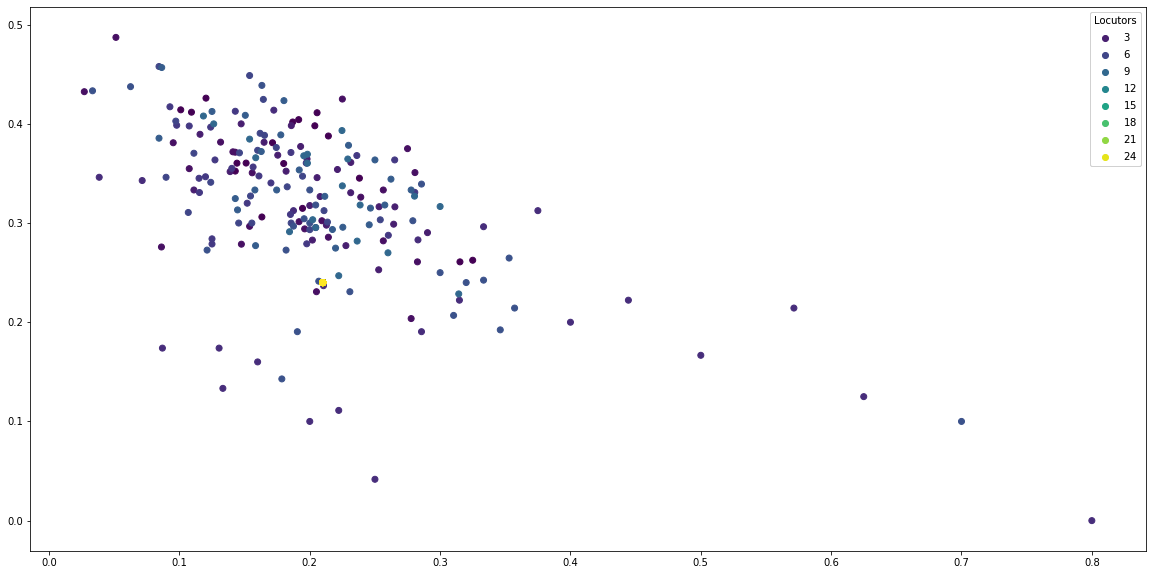

In [100]:
fig, ax = plt.subplots(figsize=(20,10))
scatter = ax.scatter(p[p.tier == loc].lexical_richness, p[p.tier == loc].linguistic_complexity, c=p[p.tier == loc].locutor)
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Locutors")
ax.add_artist(legend1)
plt.show()

In [ ]:
sns.jointplot(p[(p.tier == loc) & (p.conv == 1)].lexical_richness, 
            p[(p.tier == loc) & (p.conv == 1)].linguistic_complexity, kind='kde')

# Observe blanks


Il faut joindre les left/right + pour chaque dernier timestamp _end_ chercher le plus proche voisin dans _start_ (left ou right). Ces timestamps peuvent être pop (ils ne sont plus utiles par la suite)

In [141]:
def analyse_blanks(file_conv, file_part, minimum_length=0.):
    """
    Input:
    ------------
    file_conv: str
        location of locutor 1
    file_part: str
        location of locutor 2
    minimum_length: float
        duration of short answers to remove - for Spacy analysis
    
    Output:
    ------------
    p: pd.DataFrame
        dataframe of shape ['stop_time', 'start_time', 'loc_1', 'loc_2', 'duration']
    """
    p = []
    # file to data 
    tier_conv = extract_tier(file_conv)
    data_conv = get_ipu(tier_conv, minimum_length)
    # cannot use 'start' as index since float imprecision leads to KeyErrors
    data_conv = data_conv.set_index(data_conv.start.astype(str)) 
    idx_conv = list(data_conv.start.values)
    #
    tier_part = extract_tier(file_part)
    data_part = get_ipu(tier_part, minimum_length)
    data_part = data_part.set_index(data_part.start.astype(str))
    idx_part = list(data_part.start.values)
    # assemble data
    data = [data_conv, data_part]
    loc = [idx_conv, idx_part]
    
    # put together
    argmin_idx = int(idx_conv[0] > idx_part[0]) # argmin_idx = (loc_1 == 'conversant') # REVERSE ORDER OF DATA
    ts = loc[argmin_idx].pop(0)
    while loc[0] != [] and loc[1] != []:
        if loc[argmin_idx][0] < loc[1-argmin_idx][0]: # if the locutor doesn't change between two ipus
            ts = loc[argmin_idx].pop(0)               # we still look at the end of his ipus
        else: # if the locutor changes
            p.append({'stop_time': data[argmin_idx].loc[str(ts)].stop, \
                      'start_time': data[1-argmin_idx].loc[str(loc[1-argmin_idx][0])].start, \
                      'loc_1': 'conversant' if argmin_idx else 'participant', \
                      'loc_2': 'participant' if argmin_idx else 'conversant'})
            # update data
            ts = loc[1-argmin_idx].pop(0)
            argmin_idx = 1 - argmin_idx
    
    p = pd.DataFrame(p)
    p['duration'] = p.start_time - p.stop_time
    return p

In [40]:
analyse_blanks('convers/head/Transcriptions/S01_Sess1_CONV2_002-conversant.TextGrid', \
               'convers/head/Transcriptions/S01_Sess1_CONV2_002-participant.TextGrid')

,loc_1,loc_2,start_time,stop_time,duration
0,conversant,participant,5.544989,4.964898,0.580091
1,participant,conversant,6.810023,6.529977,0.280045
2,conversant,participant,10.774966,10.369977,0.404989
3,participant,conversant,13.444989,12.258962,1.186027
4,conversant,participant,18.249977,17.949977,0.300000
5,participant,conversant,21.664989,20.208914,1.456075
6,conversant,participant,28.240000,27.789977,0.450023
7,participant,conversant,32.449977,31.689977,0.760000
8,conversant,participant,40.184989,38.689977,1.495011
9,participant,conversant,43.620000,42.469977,1.150023


Une fois qu'on a ça: on peut automatiser et regarder les blancs `conversants > participant`

In [142]:
def concatenate_blanks(input_folder, minimum_length=0.):
    p = []
    for f in sorted(os.listdir(input_folder)):
        if 'conversant.TextGrid' in f:
            try:
                df = analyse_blanks(os.path.join(input_folder, f), 
                                    os.path.join(input_folder,(f.replace('conversant', 'participant'))),
                                    minimum_length)
                df['sub'], df['block'], df['conv'], df['nb'], _ = filename_analyser(f)
                p.append(df)
            except:
                print(f)
    p = pd.concat(p)
    return p

In [42]:
p = concatenate_blanks('convers/head/Transcriptions/')

S04_Sess3_CONV2_002-conversant.TextGrid
S16_Sess3_CONV2_004-conversant.TextGrid
S25_Sess4_CONV1_003-conversant.TextGrid


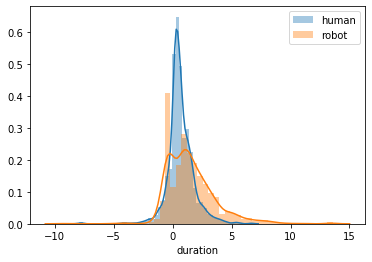

In [43]:
for i,l in enumerate(['human', 'robot']):
    sns.distplot(p[(p.loc_1 == 'conversant') & (p.conv == i+1)].duration, label=l)
plt.legend()
plt.show()

Pour l'humain: 
* pic autour de 0 : les interventions créent des coupures rapides

Pour le robot:
* pic avant 0 : plus lent puisque le robot ne peut pas s'arrêter
* pic après 0 : délai plus long à la reprise de parole de l'humain, réponse non préférée ?

Analyse plus générale des blancs et des overlaps :

# Heterorepetition
Utilisation de SPPAS en ligne de commande - nécessité de modifier le fichier `searchtier.py` pour accepter le tier `transcription` plutôt que `align token`

In [44]:
def one_OR(file_loc1, file_loc2):
    """Applying otherrepetition.py from SPPAS to locate heterorepetitions
    (Also could be called from within notebook)
    """
    # storing data
    rep = []
    # creating regex pattern for '{3.6f} {3.6f} {bool}' line
    pat = re.compile('([0-9]+([.][0-9]{6})) ([0-9]+([.][0-9]{6})) (True|False)')
    # creating and executing command
    s = "python SPPAS/sppas/bin/otherrepetition.py -r SPPAS/resources/vocab/fra.stp -i {} -s {}".format(file_loc1, file_loc2)
    l = os.popen(s).read().split('\n')
    
    # parsing result
    for line in l:
        if re.search(pat, line) is not None:
            rep.append(ast.literal_eval(line.split(' ')[-1]))
    
    return sum(rep)/len(rep)

In [45]:
one_OR('convers/head/Transcriptions/S01_Sess1_CONV1_001-participant.TextGrid', 
      'convers/head/Transcriptions/S01_Sess1_CONV1_001-conversant.TextGrid')

0.13333333333333333

In [53]:
def concatenate_OR(input_folder, tier_1 = 'conversant', tier_2 = 'participant'):
    p = []
    for f in sorted(os.listdir(input_folder)):
        df = {}
        df['sub'], df['block'], df['conv'], df['nb'], _ = filename_analyser(f)
        if 'conversant.TextGrid' in f and df['sub'] < 3:
            try:
                df['ratio_repet'] = one_OR(os.path.join(input_folder, f.replace('conversant', tier_1)), 
                                    os.path.join(input_folder,(f.replace('conversant', tier_2))))
                p.append(df)
            except:
                print(f)
    p = pd.DataFrame(p)
    return p

In [49]:
p = concatenate_OR('convers/head/Transcriptions/')

In [50]:
p.head()

,block,conv,nb,ratio_repet,sub
0,1,1,1,0.187500,1
1,1,1,3,0.000000,1
2,1,1,5,0.066667,1
3,1,2,2,0.000000,1
4,1,2,4,0.250000,1


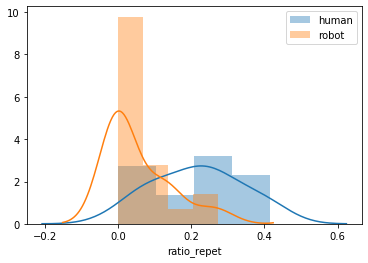

In [52]:
for i,l in enumerate(['human', 'robot']):
    sns.distplot(p[p.conv == i+1].ratio_repet, label=l)
plt.legend()
plt.show()

En inversant, y a-til une différence ?

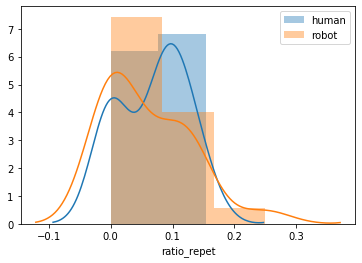

In [54]:
p = concatenate_OR('convers/head/Transcriptions/', 'participant', 'conversant')

for i,l in enumerate(['human', 'robot']):
    sns.distplot(p[p.conv == i+1].ratio_repet, label=l)
plt.legend()
plt.show()

Plus mixé, ce qui est logique puisque le robot a un vocabulaire prédéfini et des interjections plus complexes.

# Débit, Alignement lexical, Alignement syntactique

## Débit global

In [10]:
remove_lemmas = {'aux':["avoir", "aller", "devoir", "pouvoir", "venir", "vouloir", "savoir", "faire", "falloir"], 
                    'etat':["être", "devenir", "paraître", "sembler", "ressembler", "rester", "apparaître", "tomber", "vivre"] }
# patterns à conserver: NOUN, ADJ, VERB - si lemma pas dans la liste

In [82]:
vowels = ['ouai','eui','uei','yeu','oeu','eau','uoi','oui','aie','eâ','uê','uî', 'ui','eû','oî','oû','oi','ué','où','io','ie','ue','oy','ai','eu','ei','au','ou','ée','ë','ü','ï','â','ô','ê','î','û','è','à','ù','é','y','i','a','e','o','u']

In [24]:
s = "on a retrouvé la fraise ça va et t'as et non elle a pas l'air contente elle a l'air un peu en colère comme si elle voulait taper quelqu'un ah tu penses que et oui mais du coup elle elle elle vient de loin tu penses plutôt qu'elle vient de loin ou que y a pas de pesticides dedans parce que c'est deux sujets différents ah c'est soit soit elle vient de loin soit c'est parce qu'elle a elle a pas été traitée c'est peut-être même les deux mais dans ces cas là c'est bête parce que si elle a fait le voyage elle risque pas d'arriver en bon état elle va partir à la poubelle c'est dommage c'est du gâchis".replace('qu','q')

s1 = []
for wd in s.split():
    if len(wd) <= 2:
        s1.append(wd)
    elif wd[-1] == 'e':
        s1.append(wd[:-1])
    elif wd[-2:] == 'es' and len(wd) > 4:
        s1.append(wd[:-2])
    else:
        s1.append(wd)
    #s1.append((wd+' ').replace('e ', ' ')[:-1] if (len(wd) > 2 and wd != 'que') else wd)
    #print(wd, s1[-1])
s1 = ' '.join(s1)

vw_replaced = []
for vw in vowels:
    vw_replaced.append((vw, len(re.findall(vw, s1))))
    s1 = s1.replace(vw, "XXX")
s2 = s1.split("XXX")
#s2

In [25]:
len([ss for ss in s2 if ss not in ['']])-1

144

In [26]:
len(re.findall('XXX',s1))

146

In [18]:
vw_replaced

[('oeu', 0),
 ('eau', 0),
 ('uoi', 0),
 ('oui', 0),
 ('aie', 0),
 ('eâ', 0),
 ('uê', 0),
 ('uî', 0),
 ('ui', 0),
 ('eû', 0),
 ('oî', 0),
 ('oû', 0),
 ('oi', 0),
 ('ué', 0),
 ('où', 0),
 ('io', 0),
 ('ie', 0),
 ('ue', 0),
 ('oy', 0),
 ('ai', 1),
 ('eu', 3),
 ('ei', 0),
 ('au', 1),
 ('ou', 2),
 ('ée', 0),
 ('ë', 0),
 ('ü', 0),
 ('ï', 0),
 ('â', 0),
 ('ô', 0),
 ('ê', 1),
 ('î', 0),
 ('û', 0),
 ('è', 0),
 ('à', 2),
 ('ù', 0),
 ('é', 2),
 ('y', 1),
 ('i', 2),
 ('a', 6),
 ('e', 18),
 ('o', 1),
 ('u', 9)]

In [31]:
count_syllables(s)

146

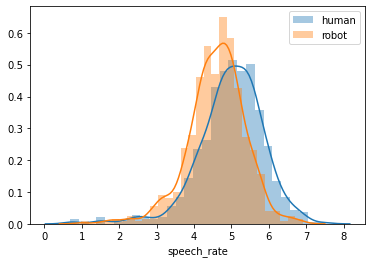

In [69]:
for i,l in enumerate(['human', 'robot']):
    sns.distplot(p[p.conv == i+1].speech_rate, label=l)
plt.legend()
plt.show()

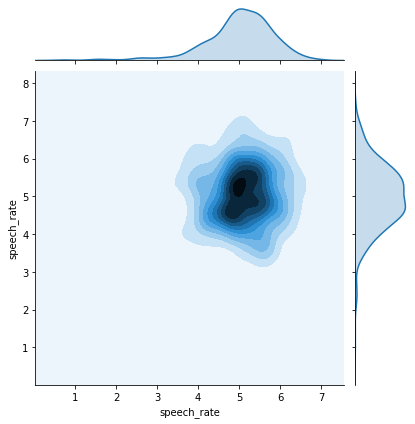

In [70]:
sns.jointplot(p_marsa[(p.tier == 'conversant') & (p.conv == 1)].speech_rate, 
              p_marsa[(p.tier == 'participant') & (p.conv == 1)].speech_rate, kind='kde')

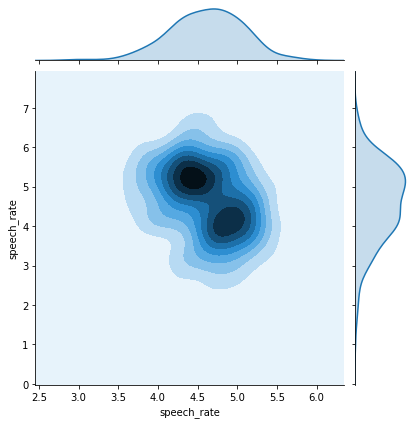

In [71]:
sns.jointplot(p_marsa[(p.tier == 'conversant') & (p.conv == 2)].speech_rate, 
              p_marsa[(p.tier == 'participant') & (p.conv == 2)].speech_rate, kind='kde')

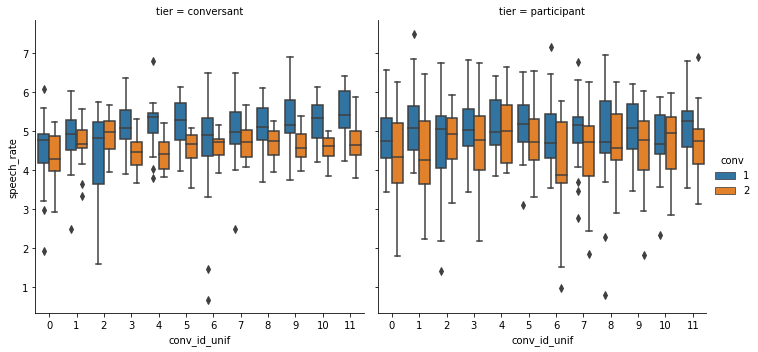

In [73]:
sns_plot = sns.catplot(x="conv_id_unif", y="speech_rate", hue="conv", col="tier", data=p, kind="box")

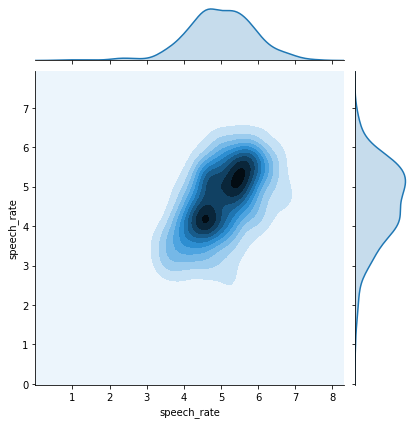

In [75]:
sns.jointplot(p_marsa[(p.tier == 'participant') & (p.conv == 1)].speech_rate, 
              p_marsa[(p.tier == 'participant') & (p.conv == 2)].speech_rate, kind='kde')

## LILLA
1. Obtenir les conversations - début / fin / locuteur
2. Pour chaque tirade du conversant : <br>
    a. prendre toutes les tirades du participant précédentes : les grouper, sortir le vocabulaire (POS) <br>
    b. extraire le vocabulaire nouveau <br>
    c. prendre toutes les tirades du participant suivantes : compter le nombre d'occurrences pour chaque mot
3. Retourner : la liste des mots et leur nombre d'occurrences

In [127]:
def create_conversation(file_conv, file_part, minimum_length=0., remove_laughter=True):
    """
    Doc for sequential groupby: https://stackoverflow.com/questions/53091343/pandas-groupby-sequential-values

    Input:
    ------------
    file_conv: str
        location of locutor 1
    file_part: str
        location of locutor 2
    minimum_length: float
        duration of short answers to remove - for Spacy analysis
    remove_laughter: bool
        whether to remove laughter (and by extension, ipus comprised of laugther only)
    
    Output:
    ------------
    p: pd.DataFrame
        dataframe of shape ['start_time', 'stop_time', 'tier', 'concatenated_text']
    """
    # file to data 
    p = []
    for f,n in zip([file_conv, file_part], ["conversant", "participant"]):
        tier_conv = extract_tier(f)
        data_conv = get_ipu(tier_conv, minimum_length)
        data_conv["tier"] = n
        p.append(data_conv.drop(np.where(data_conv.label == '@')[0])) # removing laughters - feedback => not removed
    p = pd.concat(p).sort_values(by='start').reset_index(drop=True)
    p.label = p.label.apply(lambda x: x.replace('@', ''))
    df = p.groupby((p.tier!=p.tier.shift()).cumsum()).agg(**{'concatenated_text':pd.NamedAgg(column='label', aggfunc= (lambda x: ' '.join(x))),
                                                            'start_time':pd.NamedAgg(column='start', aggfunc= min),
                                                            'stop_time': pd.NamedAgg(column='stop', aggfunc= max) }).reset_index(drop=True)
    add_tier = ('conversant', 'participant') if p.tier[0] == 'conversant' else ('participant', 'conversant')
    df['tier'] = [ add_tier[i%2] for i in range(df.shape[0])]
    return df

In [128]:
create_conversation('convers/head/Transcriptions/S08_Sess3_CONV1_003-conversant.TextGrid', 'convers/head/Transcriptions/S08_Sess3_CONV1_003-participant.TextGrid', 0.5)

,concatenated_text,start_time,stop_time,tier
0,soit c'était encore le citron $Tortue Ninja$ e...,2.654623,20.409977,participant
1,c'est vrai que c'est assez ironique de mettre ...,21.044989,25.509977,conversant
2,ouais,26.150326,26.994921,participant
3,avec les olives,28.689977,29.529977,conversant
4,ouais voilà c'est ça euh si si ça fait un peu ...,29.964989,46.049977,participant
5,ah et c'est pour,47.215011,47.764989,conversant
6,comme il faut le salades,47.453090,49.009977,participant
7,c'est pour ça que lui il serait pas triste ou ...,49.400000,51.649977,conversant


In [142]:
def extract_pv_text(df, tier='conversant'):
    """ Extracting, for each line of "tier", what comes before / after for the other locutor

    Input:
    --------
    df: pd.DataFrame
        output of create_conversation, shape ['start_time', 'stop_time', 'tier', 'concatenated_text']
        every line is a different locutor
    tier: str
        in 'conversant', 'participant'
    
    Output:
    --------
    pv_text: list 
        list of dict of shape ['before_oth', 'tier', 'after_oth'] containing concatenated dialog
    """
    oth = 'participant' if tier == 'conversant' else 'conversant'
    pv_text = []
    for i in list(df[df.tier == tier].index):
        pv_text.append({'before_oth': ' '.join(df[(df.tier == oth) & (df.index < i)][:i].concatenated_text), 
                        'tier': df.concatenated_text[i],
                        'after_oth': ' '.join(df[(df.tier == oth) & (df.index >= i)].concatenated_text)})
    return pv_text

In [148]:
df = create_conversation('convers/head/Transcriptions/S08_Sess3_CONV1_003-conversant.TextGrid', 'convers/head/Transcriptions/S08_Sess3_CONV1_003-participant.TextGrid', 0.5)
df.concatenated_text = df.concatenated_text.apply(lambda x: clean_text(x, patterns_dic).replace('*', ''))

In [149]:
extract_pv_text(df)

[{'before_oth': "soit c'était encore le citron Tortue Ninja euh c'était  ben un peu  le ski euh le truc que les Tortues Ninja s'aventurent  pizza hein parce que ben si un peu bien",
  'tier': "c'est vrai que c'est assez ironique de mettre ça en fruit du coup euh une part de pizza peut-être",
  'after_oth': "ouais  ouais voilà c'est ça euh si si ça fait un peu contraste avec les autres fruits par rapport ces super héros qui veulent euh sauver euh les autres fruits qui sont plein de tristesse qui vont pas manger comme il faut le salades"},
 {'before_oth': "soit c'était encore le citron Tortue Ninja euh c'était  ben un peu  le ski euh le truc que les Tortues Ninja s'aventurent  pizza hein parce que ben si un peu bien ouais ",
  'tier': 'avec les olives',
  'after_oth': "ouais voilà c'est ça euh si si ça fait un peu contraste avec les autres fruits par rapport ces super héros qui veulent euh sauver euh les autres fruits qui sont plein de tristesse qui vont pas manger comme il faut le salad

In [ ]:
# obtenir les lengths


In [157]:
def extract_vocab_count(df, nlp = sp.load('fr_core_news_sm'), keep_POS = ['NOUN', 'ADJ', 'VERB'], exceptions = [y for x in remove_lemmas.values() for y in x]):
    """ Extracts vocabulary introduced by locutor, and counts occurences in posterior dialog by other participant

    Input:
    --------
    df: pd.DataFrame or list
        output of extract_pv_text, shape ['before_oth', 'tier', 'after_oth']
    nlp: Spacy.nlp
        language POS parser
    keep_POS: list
        list of strings, of POS tags to keep for content (lemmas)
    exceptions: list
        list of strings, lemmas of verbs not to count in content words
    
    Output:
    --------
    l: list
        list of lists (one list: 1 sentence - sublist: tuples ('word', 'nb_occurrences'))
    ignored_vocab: list
        list of vocab introducted by the other locutor
    """
    l = []
    tier_vocab = []
    ignored_vocab = []
    d_marsa = {'ADJ': 'ADJ', 'ADP':'PREP', 'ADV': 'ADV', 'AUX': 'VERB', 'CONJ':'CONJ', 'CCONJ':'CONJ', \
              'DET':'DET', 'INTJ': 'INTJ', 'NOUN':'NOUN', 'NUM':'DET', 'PART':'ADV', 'PRON':'PRON', \
              'PROPN':'NOUN', 'PUNCT':'PUNCT', 'SCONJ':'CONJ', 'SYM':'X', 'VERB':'VERB', 'X':'X', 'SPACE':'SPACE'}
    for d in df: # for each conversant sentence
        # 1. Apply POS tagging - nlp - on every sentence.
        pre = nlp(d['before_oth'])
        post = nlp(d['after_oth'])
        # 2. Add vocab matching keep_POS tags to curr_vocab / ignored_vocab (lemmas)
        ignored_vocab += [ x.lemma_ for x in pre if (d_marsa[x.pos_] in keep_POS) and (x.lemma_ not in exceptions) ]
        curr_vocab = [ x.lemma_ for x in nlp(d['tier']) if (d_marsa[x.pos_] in keep_POS) and (x.lemma_ not in exceptions) and (x.lemma_ not in set(ignored_vocab))]
        tier_vocab += curr_vocab # for analysis
        # 3. Count vocab in post speech
        l.append(Counter([x.lemma_ for x in post if x.lemma_ in curr_vocab]))

    return l, list(set(ignored_vocab)), list(set(tier_vocab))

In [159]:
extract_vocab_count(extract_pv_text(df, tier="conversant"))

([Counter({'fruit': 2}), Counter(), Counter(), Counter()],
 ['contraster',
  'super',
  'fruit',
  'citron',
  'Tortue',
  'manger',
  'autre',
  'aventurer',
  'sauver',
  'héros',
  'Tortues',
  'pizza',
  'ouais',
  'ski',
  'voilà',
  'rapport',
  'salade',
  'truc',
  'hein',
  'Ninja',
  'plein',
  'tristesse'],
 ['vrai',
  'ironique',
  'olive',
  'ah',
  'triste',
  'fruit',
  'mettre',
  'coup',
  'colère',
  'partir'])

# Data Extraction

In [143]:
h = []
for file_part in ['S04_Sess3_CONV2_002-conversant.TextGrid', 
                  'S16_Sess3_CONV2_004-conversant.TextGrid',
                  'S25_Sess4_CONV1_003-conversant.TextGrid']:
    file_part = os.path.join('convers/head/Transcriptions/', file_part)
    print(file_part)
    tier_part = extract_tier(file_part)
    h.append(get_ipu(tier_part, 0))
    file_part = file_part.replace('conversant', 'participant')
    print(file_part)
    tier_part = extract_tier(file_part)
    h.append(get_ipu(tier_part, 0))

convers/head/Transcriptions/S04_Sess3_CONV2_002-conversant.TextGrid
convers/head/Transcriptions/S04_Sess3_CONV2_002-participant.TextGrid
convers/head/Transcriptions/S16_Sess3_CONV2_004-conversant.TextGrid
convers/head/Transcriptions/S16_Sess3_CONV2_004-participant.TextGrid
convers/head/Transcriptions/S25_Sess4_CONV1_003-conversant.TextGrid
convers/head/Transcriptions/S25_Sess4_CONV1_003-participant.TextGrid


In [125]:
h[0].label.values[1]

'on dirait un $Spiderman$ cette pomme'

In [144]:
[df.shape for df in h]

[(8, 4), (3, 4), (0, 0), (16, 4), (11, 4), (15, 4)]

In [146]:
p = []
input_folder = 'convers/head/Transcriptions/'
for f in ['S04_Sess3_CONV2_002-conversant.TextGrid', 
#          'S16_Sess3_CONV2_004-conversant.TextGrid',
          'S25_Sess4_CONV1_003-conversant.TextGrid']:
    if 'conversant.TextGrid' in f:
        print(f)
        df = analyse_blanks(os.path.join(input_folder, f), 
                            os.path.join(input_folder,(f.replace('conversant', 'participant'))))
        df['sub'], df['block'], df['conv'], df['nb'], _ = filename_analyser(f)
        p.append(df)

S04_Sess3_CONV2_002-conversant.TextGrid
S25_Sess4_CONV1_003-conversant.TextGrid


In [150]:
h[4]

,duration,label,start,stop
0,1.115102,par contre,2.069887,3.184989
1,1.240000,y a un truc auquel j'ai pensé,3.929977,5.169977
2,1.449932,euh,6.155011,7.604943
3,3.794785,si c'est ceux qui sont censés être nature parc...,8.010023,11.804807
4,1.915011,tu sais la la framboise $Oasis$ qu'on avait vu,12.554966,14.469977
5,1.094966,elle a pas l'air,14.975011,16.069977
6,1.760000,super naturelle et t'avais dit toi même,16.329977,18.089977
7,2.924989,plutôt que c'était un quelque chose de synthèse,18.284989,21.209977
8,2.084989,euh du coup comment est ce que t'expliquerais ça,23.684989,25.769977
9,0.460000,mh mh,51.829977,52.289977


In [151]:
p[1]

,loc_1,loc_2,start_time,stop_time,duration,sub,block,conv,nb
0,participant,conversant,5.609887,5.169977,0.439909,25,4,1,3
1,conversant,participant,6.155011,5.809977,0.345034,25,4,1,3
2,participant,conversant,15.000000,16.069977,-1.069977,25,4,1,3
3,conversant,participant,16.329977,15.289977,1.040000,25,4,1,3
4,participant,conversant,21.500000,21.209977,0.290023,25,4,1,3
5,conversant,participant,23.684989,21.769977,1.915011,25,4,1,3
6,participant,conversant,27.244989,25.769977,1.475011,25,4,1,3
7,conversant,participant,51.829977,51.134966,0.695011,25,4,1,3
8,participant,conversant,51.864989,52.289977,-0.424989,25,4,1,3


## Extract IPU/Silence
1 ligne = 
* sub, block, conv, nb 
* texte_left / sum_ipu_left / mean_ipu_left / std_ipu_left / text_subjectivity / text_
* texte_right / sum_ipu_right / mean_ipu_right / std_ipu_right / 

In [161]:
def extract_dialogues(input_folder):
    p = []
    input_folder = 'convers/head/Transcriptions/'
    for f in sorted(os.listdir(input_folder)):
        if 'conversant.TextGrid' in f:
            print(f)
            file_part = os.path.join('convers/head/Transcriptions/', file_part)
            print(file_part)
            tier_part = extract_tier(file_part)
            h.append(get_ipu(tier_part, 0))
            file_part = file_part.replace('conversant', 'participant')
            print(file_part)
            tier_part = extract_tier(file_part)
            h.append(get_ipu(tier_part, 0))
            df = analyse_blanks(os.path.join(input_folder, f), 
                                os.path.join(input_folder,(f.replace('conversant', 'participant'))))
            df['sub'], df['block'], df['conv'], df['nb'], _ = filename_analyser(f)
            p.append(df)

,duration,label,start,stop
0,1.620091,cette pomme est à l'envers,2.109887,3.729977
1,2.029977,on dirait un $Spiderman$ cette pomme,4.260000,6.289977
2,1.424989,tu as une idée du message,10.364989,11.789977
3,2.360000,elle combat peut-être la mauvaise nourriture,14.949977,17.309977
4,1.440000,tu as une idée du message,24.489977,25.929977
5,2.104989,c'est un logo d'un club de végétarien,32.344989,34.449977
6,1.080000,qu'est ce que t'en penses,43.949977,45.029977
7,0.480000,ah oui,56.709977,57.189977


# Subjectivité
https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/

In [42]:
parse_sentiment("bonjour Morgane on dirait une ça fait penser euh euh parc d'attraction avec euh avec trou la un peu comme une citrouille mais en forme d'aubergine ok j'essaye c'est mieux comme ça voilà donc je euh oui ça me fait penser aux citrouilles dans lesquelles on met une bougie euh pour euh oui euh faut les écorcher aussi pour pouvoir mettre la bougie dedans un peu ouais donc euh ouais c'est étonnant pour un fruit pour un légume justement euh vision d'horreur c'était")

Sentiment(polarity=0.5, subjectivity=0.5)

In [186]:
p_marsa, s_marsa = folder_analysis('convers/head/Transcriptions',
                                   [lexical_richness, linguistic_complexity,
                                    extract_text, extract_sentiment, extract_subjectivity],
                      marsa_exists=True, ipu_analysis=True, minimum_length=0.)
#p_spacy, s_spacy = folder_analysis('convers/head/Transcriptions', [lexical_richness, linguistic_complexity], \
#                      pos_analyser='spacy')
# problèmes avec spacy dus à des séparations du type 'est-ce' où '-ce' n'est pas compris => token ''

/Users/neako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


S09_Sess4_CONV2_002-participant.TextGrid
S16_Sess3_CONV2_004-conversant.TextGrid


Grand nombre d'erreurs spacy:
```
convers/head/Transcriptions/S01_Sess3_CONV1_005-participant.TextGrid
convers/head/Transcriptions/S01_Sess3_CONV2_002-conversant.TextGrid
convers/head/Transcriptions/S01_Sess3_CONV2_002-participant.TextGrid
convers/head/Transcriptions/S01_Sess3_CONV2_004-participant.TextGrid
convers/head/Transcriptions/S02_Sess4_CONV2_002-conversant.TextGrid
convers/head/Transcriptions/S04_Sess1_CONV1_005-conversant.TextGrid
convers/head/Transcriptions/S04_Sess3_CONV1_001-conversant.TextGrid
convers/head/Transcriptions/S04_Sess4_CONV1_005-conversant.TextGrid
convers/head/Transcriptions/S05_Sess3_CONV2_006-participant.TextGrid
convers/head/Transcriptions/S06_Sess4_CONV2_002-conversant.TextGrid
convers/head/Transcriptions/S06_Sess4_CONV2_006-conversant.TextGrid
convers/head/Transcriptions/S08_Sess2_CONV1_001-participant.TextGrid
convers/head/Transcriptions/S10_Sess1_CONV1_001-conversant.TextGrid
convers/head/Transcriptions/S10_Sess2_CONV2_004-conversant.TextGrid
convers/head/Transcriptions/S10_Sess4_CONV2_002-conversant.TextGrid
convers/head/Transcriptions/S12_Sess2_CONV2_004-participant.TextGrid
convers/head/Transcriptions/S12_Sess2_CONV2_006-participant.TextGrid
convers/head/Transcriptions/S13_Sess1_CONV1_001-participant.TextGrid
convers/head/Transcriptions/S13_Sess1_CONV2_006-participant.TextGrid
convers/head/Transcriptions/S13_Sess3_CONV1_005-conversant.TextGrid
convers/head/Transcriptions/S13_Sess3_CONV2_002-conversant.TextGrid
convers/head/Transcriptions/S13_Sess3_CONV2_004-conversant.TextGrid
convers/head/Transcriptions/S13_Sess4_CONV1_003-conversant.TextGrid
convers/head/Transcriptions/S13_Sess4_CONV2_004-conversant.TextGrid
convers/head/Transcriptions/S16_Sess1_CONV2_002-participant.TextGrid
convers/head/Transcriptions/S16_Sess2_CONV2_006-participant.TextGrid
convers/head/Transcriptions/S16_Sess3_CONV2_004-conversant.TextGrid
convers/head/Transcriptions/S17_Sess2_CONV1_005-conversant.TextGrid
convers/head/Transcriptions/S18_Sess1_CONV1_001-conversant.TextGrid
convers/head/Transcriptions/S18_Sess4_CONV1_003-participant.TextGrid
convers/head/Transcriptions/S19_Sess3_CONV1_005-conversant.TextGrid
convers/head/Transcriptions/S19_Sess3_CONV2_002-participant.TextGrid
convers/head/Transcriptions/S19_Sess3_CONV2_004-participant.TextGrid
convers/head/Transcriptions/S19_Sess3_CONV2_006-conversant.TextGrid
convers/head/Transcriptions/S19_Sess4_CONV2_004-participant.TextGrid
convers/head/Transcriptions/S19_Sess4_CONV2_006-conversant.TextGrid
convers/head/Transcriptions/S21_Sess3_CONV1_003-conversant.TextGrid
convers/head/Transcriptions/S22_Sess2_CONV2_006-conversant.TextGrid
convers/head/Transcriptions/S22_Sess3_CONV2_006-participant.TextGrid
convers/head/Transcriptions/S23_Sess4_CONV1_005-participant.TextGrid
convers/head/Transcriptions/S24_Sess3_CONV1_005-conversant.TextGrid
```

In [187]:
p_marsa.head()

,block,conv,conv_id_unif,data,extract_sentiment,extract_subjectivity,extract_text,it,lexical_richness,linguistic_complexity,locutor,mean_ipu_lgth,ratio_silence_lgth,sum_ipu_lgth,tier
0,1,1,0,form inserted lemma pos...,0.50,1.00,ah ouais c'est un masque de Batman je sais pas...,1,0.144737,0.394737,1,1.416431,0.639890,21.246472,conversant
1,1,1,0,form inserted lemma pos 0 ...,0.00,0.00,donc concernant l'image il s'agissait d'une d'...,1,0.191489,0.404255,1,1.722022,0.620571,22.386290,participant
2,1,1,1,form inserted lemma ...,0.45,0.55,ah d'accord ok ouais donc on on on a vu exacte...,3,0.198198,0.342342,1,2.756391,0.579534,24.807521,conversant
3,1,1,1,form inserted lemma ...,0.50,0.50,ok donc là il s'agissait d'un demi citron vert...,3,0.163265,0.306122,1,1.562561,0.576255,25.000977,participant
4,1,1,2,form inserted lemma pos 0...,0.00,0.00,c'est c'est la pomme que j'avais pas vu ah oua...,5,0.123810,0.333333,1,1.831765,0.565344,25.644715,conversant


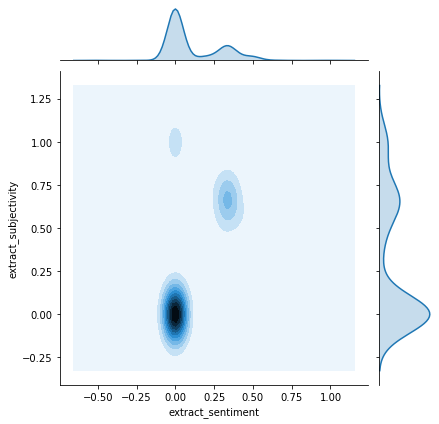

In [99]:
sns.jointplot(p_marsa[p.tier == 'participant'].extract_sentiment, 
              p_marsa[p.tier == 'participant'].extract_subjectivity, kind='kde')

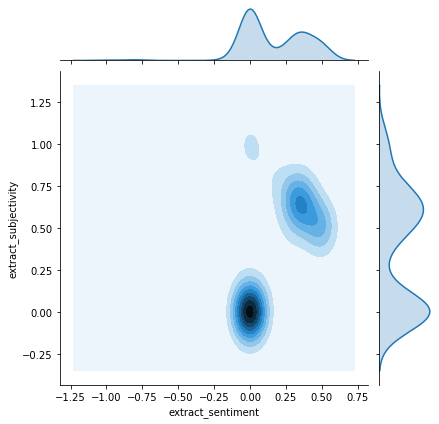

In [101]:
sns.jointplot(p_marsa[(p.tier == 'conversant') & (p.conv == 1)].extract_sentiment, 
              p_marsa[(p.tier == 'conversant') & (p.conv == 1)].extract_subjectivity, kind='kde')

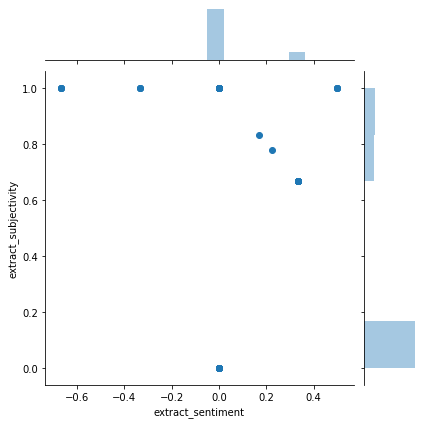

In [103]:
sns.jointplot(p_marsa[(p.tier == 'conversant') & (p.conv == 2)].extract_sentiment, 
              p_marsa[(p.tier == 'conversant') & (p.conv == 2)].extract_subjectivity)

In [91]:
parse_sentiment(p_marsa.loc[1].extract_text)

Sentiment(polarity=0.0, subjectivity=0.0)

# Métriques de Youssef

In [46]:
OK_FORMS = [u"o.k.",u"okay",u"ok",u"OK",u"O.K."]
VOILA_FORMS = [u"voilà",u"voila"]
DACCORD_FORMS = [u"d'accord",u"d' accord"]
LAUGHTER_FORMS = [u'@',u'@ @',u'@@']
EMO_FORMS = [u'@',u'@ @',u'@@',u'ah',u'oh']

REGULATORY_DM_SET = set([u"mh",u"ouais",u"oui",u"o.k.",u"okay",u"ok",u"OK",u"O.K.",u"d'accord",u"voilà",u"voila",u'bon',u"d'",
u"accord",u'@',u'@ @',u'@@',u'non',u"ah",u"euh",u'ben',u"et",u"mais",u"*",u"heu",u"hum",u"donc",u"+",u"eh",u"beh",u"donc",u"oh",u"pff",u"hein"])

FILLED_PAUSE_ITEMS = [u"euh",u"heu",u"hum",u"mh"]
SILENCE = [u'+',u'#',u'',u'*']
LAUGHTER = [u'@',u'@@']

MAIN_FEEDBACK_ITEMS = [u"mh",u"ouais",u"oui",u'non',u'ah',u"mouais"]+ OK_FORMS + VOILA_FORMS + DACCORD_FORMS + LAUGHTER_FORMS
MAIN_DISCOURSE_ITEMS = [u"alors",u"mais",u"donc",u'et',u'puis',u'enfin',u'parceque',u'parcequ',u'ensuite']
MAIN_PARTICLES_ITEMS = [u"quoi",u"hein",u"bon",u'mais',u'ben',u'beh',u'enfin',u'vois',u'putain',u'bref']

On veut juste le _nombre_ d'items, donc pas besoin de passer par les fonctions de youssef.

In [35]:
data = get_ipu(extract_tier('convers/head/Transcriptions/S09_Sess1_CONV1_001-participant.TextGrid'))
print(len(' '.join(data.label.values).split(' ')), data.shape) # SPPAS TEST

86 (14, 4)


In [38]:
' '.join(data.label.values)

"bonjour $Morgane$ on dirait une ça fait penser euh euh parc d'attraction avec euh avec trou la citrou- un peu comme une citrouille mais en forme d'aubergine ok j'essaye c'est mieux comme ça voilà donc je euh oui ça me fait penser aux citrouilles dans lesquelles on met une bougie euh pour euh oui euh faut les écorcher aussi pour pouvoir mettre la bougie dedans un peu ouais @ donc euh ouais c'est étonnant pour un fruit -fin pour un légume justement euh vision d'horreur c'était"

In [44]:
def count_terms(s:str, item_list:list):
    q = 0
    for it in item_list:
        q += len(re.findall(it, s))
    return q

In [47]:
s = ' '.join(data.label.values)
count_terms(s, MAIN_FEEDBACK_ITEMS), count_terms(s, MAIN_DISCOURSE_ITEMS), count_terms(s, FILLED_PAUSE_ITEMS)

(9, 5, 9)

# Statistiques - tests

In [153]:
import scipy.stats as ss

In [ ]:
p,s = analyse_partial('convers/head/Transcriptions', [lexical_richness, linguistic_complexity])
#                      pos_analyser='spacy') # à utiliser normalement
p.head()

In [203]:
p['conv_id_unif'] = p.apply(lambda x: 3*(x['block']-1)+(x['it']-1)//2, axis=1)

In [186]:
ss.ttest_rel(p[(p.tier == 'participant') & (p.conv == 1)]['lexical_richness'],
             p[(p.tier == 'participant') & (p.conv == 2)]['lexical_richness'])

Ttest_relResult(statistic=-3.94063352625576, pvalue=0.00010144936886186126)

In [183]:
ss.ttest_rel(p[(p.tier == 'participant') & (p.conv == 1)]['linguistic_complexity'],
             p[(p.tier == 'participant') & (p.conv == 2)]['linguistic_complexity'])

Ttest_relResult(statistic=-0.6882212314445683, pvalue=0.49185246945038974)

In [184]:
ss.pearsonr(p[(p.tier == 'participant')]['linguistic_complexity'],
             p[(p.tier == 'participant')]['lexical_richness'])

(-0.6023867149461974, 6.109417331953222e-60)

In [107]:
from statsmodels.stats.anova import AnovaRM

In [207]:
aovrm = AnovaRM(p[(p.tier == 'participant') & (p.locutor >1)], 'lexical_richness', 'locutor', 
                within=['conv', 'grouped_name'])
res = aovrm.fit()

print(res)

                      Anova
                  F Value  Num DF  Den DF  Pr > F
-------------------------------------------------
conv               4.7789  1.0000  23.0000 0.0392
grouped_name       5.8238 11.0000 253.0000 0.0000
conv:grouped_name  1.7268 11.0000 253.0000 0.0679



# Statistiques - variables
On a 10 variables… :
* 2 de temps :
    * Silence 
    * Overlap (reaction time)
* 3 de quantité : 
    * Feedbacks
    * Pauses remplies
    * Marqueurs discursifs
* 3 de proportions :
    * Richesse lexicale
    * Complexité linguistique
    * Complexité supplémentaire calculée par Youssef
* 2 continues :
    * Polarité
    * Subjectivité

…et 3 sources de variance :
* Nature de l’agent : humain VS robot
* Conversant VS participant 
* Les 12 sessions par participant


Donc les tests statistiques à faire sont les suivants :
* 10 ANOVA (une par variable) entre :
    * La nature de l’agent & les 12 sessions
    * Le conversant humain & le conversant robot 
* Tableau de corrélation (les variables 2 à 2) par participant, indépendamment du reste (à faire suivre par un K-means, qui sera fait sur les moyennes)
A regarder : Y-a-t-il une convergence entre les variables, entre participant et conversant ? 


In [75]:
p_marsa, s_marsa = folder_analysis('convers/head/Transcriptions',
                                   [lexical_richness, linguistic_complexity,
                                    extract_text, extract_sentiment, extract_subjectivity],
                      marsa_exists=True, ipu_analysis=True, quantity_analysis=True, speech_rate=True, minimum_length=0.)

S09_Sess4_CONV2_002-participant.TextGrid


In [76]:
p = p_marsa
p.shape

(1188, 28)

In [79]:
p.columns

Index(['lexical_richness', 'linguistic_complexity', 'extract_text',
       'extract_sentiment', 'extract_subjectivity', 'locutor', 'tier', 'block',
       'conv', 'it', 'conv_id_unif', 'nb_tokens', 'mean_ipu_lgth',
       'sum_ipu_lgth', 'ratio_silence_lgth', 'qt_feedback', 'qt_discourse',
       'qt_filled_pause', 'ratio_discourse', 'ratio_feedback',
       'ratio_filled_pause', 'count_syllables', 'speech_rate',
       'speech_rate_mean', 'speech_rate_min', 'speech_rate_max', 'data'],
      dtype='object')

In [59]:
p[[c for c in p.columns if c not in ['data', 'extract_text']]].head()

,lexical_richness,linguistic_complexity,extract_sentiment,extract_subjectivity,locutor,tier,block,conv,it,conv_id_unif,...,qt_discourse,qt_filled_pause,ratio_discourse,ratio_feedback,ratio_filled_pause,count_syllables,speech_rate,speech_rate_mean,speech_rate_min,speech_rate_max
0,0.144737,0.394737,0.50,1.00,1,conversant,1,1,1,0,...,5,10,0.065789,0.065789,0.131579,91,4.283064,4.111343,1.418463,7.538765
1,0.191489,0.404255,0.00,0.00,1,participant,1,1,1,0,...,5,4,0.053191,0.085106,0.042553,118,5.271083,4.638551,2.127762,6.315811
2,0.198198,0.342342,0.45,0.55,1,conversant,1,1,3,1,...,10,6,0.090090,0.072072,0.054054,136,5.482208,5.800914,3.846070,7.633720
3,0.163265,0.306122,0.50,0.50,1,participant,1,1,3,1,...,6,7,0.061224,0.081633,0.071429,124,4.959806,5.028425,2.353004,7.526882
4,0.123810,0.333333,0.00,0.00,1,conversant,1,1,5,2,...,4,2,0.038095,0.085714,0.019048,129,5.030276,5.134378,1.317168,7.807861


In [42]:
# vérification
p[p.ratio_silence_lgth.isna()]

,lexical_richness,linguistic_complexity,extract_text,extract_sentiment,extract_subjectivity,locutor,tier,block,conv,it,...,qt_filled_pause,ratio_discourse,ratio_feedback,ratio_filled_pause,count_syllables,speech_rate,speech_rate_mean,speech_rate_min,speech_rate_max,data


In [77]:
ordered_columns=['locutor', 'block', 'conv', 'it', 'conv_id_unif', 'tier']
removed_columns=['data', 'extract_text']
other_columns=sorted(list(set(p.columns) - set(ordered_columns) - set(removed_columns)))

p[ordered_columns + other_columns + ['extract_text']].to_excel('extracted_data_7.xlsx', index=False, header=True)

### ANOVA

In [191]:
for c in ['lexical_richness', 'linguistic_complexity', 'extract_sentiment', 
          'extract_subjectivity', 'ratio_silence_lgth']:
    #aovrm = AnovaRM(p[(p.tier == 'participant') & (p.locutor >1)], c, 'locutor',
    aovrm = AnovaRM(p[(p.locutor >1)], c, 'locutor', within=['conv', 'conv_id_unif', 'tier'])
    res = aovrm.fit()
    print(c, '\n\t', res)

lexical_richness 
	                         Anova
                       F Value  Num DF  Den DF  Pr > F
------------------------------------------------------
conv                   97.7646  1.0000  23.0000 0.0000
conv_id_unif            8.1857 11.0000 253.0000 0.0000
tier                    0.3003  1.0000  23.0000 0.5889
conv:conv_id_unif       3.3481 11.0000 253.0000 0.0002
conv:tier               4.8824  1.0000  23.0000 0.0374
conv_id_unif:tier       3.0535 11.0000 253.0000 0.0007
conv:conv_id_unif:tier  1.7544 11.0000 253.0000 0.0625

linguistic_complexity 
	                         Anova
                       F Value  Num DF  Den DF  Pr > F
------------------------------------------------------
conv                   63.2268  1.0000  23.0000 0.0000
conv_id_unif            3.5977 11.0000 253.0000 0.0001
tier                    0.1674  1.0000  23.0000 0.6862
conv:conv_id_unif       2.6219 11.0000 253.0000 0.0035
conv:tier              93.2140  1.0000  23.0000 0.0000
conv_id_unif:t

### Corrélation
https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

In [ ]:
ss.pearsonr(p[(p.tier == 'participant')]['linguistic_complexity'],
             p[(p.tier == 'participant')]['lexical_richness'])

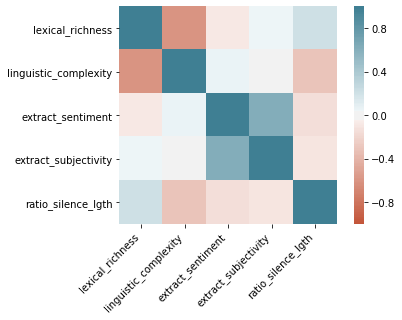

In [227]:
plt.figure()
corr = p[(p.tier == 'participant')][['lexical_richness', 
        'linguistic_complexity', 'extract_sentiment', 'extract_subjectivity', 'ratio_silence_lgth']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Modèles mixtes